<a href="https://colab.research.google.com/github/Chimamuelo/Simple-Cnn-Pytorch/blob/main/MultiLabel_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multilabel Classifier

### Dataset
* Pascal dataset can be found here at [Paperswithcode](https://paperswithcode.com/dataset/pascal-voc-2007)

In [2]:
from fastai.vision.all import *

In [3]:
#Download data
path = untar_data(URLs.PASCAL_2007)
path.ls()

(#8) [Path('/root/.fastai/data/pascal_2007/train.csv'),Path('/root/.fastai/data/pascal_2007/train.json'),Path('/root/.fastai/data/pascal_2007/train'),Path('/root/.fastai/data/pascal_2007/test'),Path('/root/.fastai/data/pascal_2007/test.json'),Path('/root/.fastai/data/pascal_2007/segmentation'),Path('/root/.fastai/data/pascal_2007/valid.json'),Path('/root/.fastai/data/pascal_2007/test.csv')]

In [4]:
#Check data information (names and labels)
df = pd.read_csv(path/'train.csv')
df[:10]

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True
5,000017.jpg,person horse,False
6,000019.jpg,cat,True
7,000020.jpg,car,True
8,000021.jpg,dog person,True
9,000023.jpg,bicycle person,False


In [5]:
df_train=df.loc[df.is_valid==True]
df_valid=df.loc[df.is_valid==False]
df_test= pd.read_csv(path/'test.csv')

In [6]:
df_train=df_train.reset_index(drop=True)
df_valid=df_valid.reset_index(drop=True)

In [7]:
df_train

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000016.jpg,bicycle,True
4,000019.jpg,cat,True
...,...,...,...
2505,009947.jpg,boat person,True
2506,009950.jpg,train person,True
2507,009954.jpg,horse person,True
2508,009955.jpg,boat,True


In [8]:
df.labels=df.labels.str.split()

df_train.labels=df_train.labels.str.split()

df_valid.labels=df_valid.labels.str.split()

### Transform labels to binary vectors
Multilabel classifiers required labels of the form:
\begin{bmatrix} 
	y_i & y_j & ... y_n \\
	\end{bmatrix}
Where:

n=total number of classes

y= binary vector [0,1] representing one of the classes

In [9]:
from sklearn.preprocessing import MultiLabelBinarizer
lb=MultiLabelBinarizer()
lab=lb.fit_transform(df.labels)
labels=lb.fit_transform(df_train.labels)
valid_labels=lb.fit_transform(df_valid.labels)

In [10]:
print(labels[8])

[0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]


In [11]:
lb.inverse_transform(labels)[4]

('cat',)

In [12]:
folder_dir = '/root/.fastai/data/pascal_2007/train'
test_dir='/root/.fastai/data/pascal_2007/test'
print(len(os.listdir(folder_dir)))

5012


In [13]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import matplotlib.image as mpimg
from torchvision.io import read_image

In [14]:

transform=transforms.Compose([
                              transforms.Resize([224,224]),
                              transforms.ToTensor(),
                              #transforms.Normalize(means,stds)

                              ]
                             )

In [15]:
class MultiDataset(Dataset):
  def __init__(self,folder_dir,y,transform,df):
    self.folder=folder_dir
    self.label=torch.tensor(y)
    self.transform=transform
    self.df=df
  def __len__(self):
    return len(self.label)
  
  def __getitem__(self, idx):
    image_path=os.path.join(self.folder,self.df.fname.iloc[idx])
    
    image=Image.open(image_path)
    img=self.transform(image)
    
    return img,self.label[idx]

In [16]:
dataset=MultiDataset(folder_dir,lab,transform,df)
train_dataset=MultiDataset(folder_dir,labels,transform,df_train)
valid_dataset=MultiDataset(folder_dir,valid_labels,transform,df_valid)

In [17]:
dataset[0]

(tensor([[[0.0392, 0.0392, 0.0353,  ..., 0.6510, 0.6392, 0.6353],
          [0.1686, 0.1216, 0.0863,  ..., 0.6431, 0.6392, 0.6392],
          [0.3961, 0.3843, 0.3569,  ..., 0.6549, 0.6588, 0.6549],
          ...,
          [0.0745, 0.0784, 0.0941,  ..., 0.2902, 0.2627, 0.2314],
          [0.1137, 0.1255, 0.2118,  ..., 0.2471, 0.2314, 0.2353],
          [0.1922, 0.2745, 0.3176,  ..., 0.2275, 0.2353, 0.2667]],
 
         [[0.0353, 0.0431, 0.0510,  ..., 0.7333, 0.7333, 0.7333],
          [0.1804, 0.1216, 0.0745,  ..., 0.7529, 0.7451, 0.7412],
          [0.4510, 0.4392, 0.4078,  ..., 0.7529, 0.7490, 0.7412],
          ...,
          [0.0353, 0.0353, 0.0275,  ..., 0.3373, 0.2980, 0.2667],
          [0.0431, 0.0471, 0.0588,  ..., 0.3020, 0.2824, 0.2863],
          [0.0549, 0.0980, 0.0863,  ..., 0.2824, 0.2980, 0.3255]],
 
         [[0.0392, 0.0431, 0.0431,  ..., 0.7647, 0.7608, 0.7569],
          [0.1922, 0.1333, 0.0863,  ..., 0.7686, 0.7725, 0.7725],
          [0.4627, 0.4549, 0.4196,  ...,

In [18]:
valid_dataset[1][0].shape

torch.Size([3, 224, 224])

In [19]:
complete=train_loader=DataLoader(dataset,shuffle=True,batch_size=32,num_workers=2)
train_loader=DataLoader(dataset,shuffle=True,batch_size=32,num_workers=2)
valid_loader=DataLoader(valid_dataset,batch_size=32,num_workers=2)

## Calculate mean and std of the Dataset

### Visualize Data image
See respective labels and binary vector representation

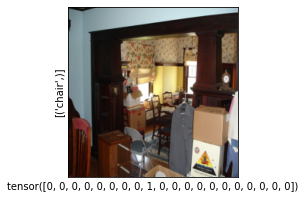

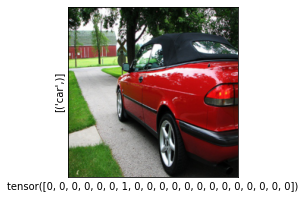

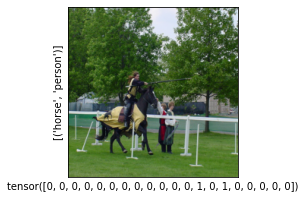

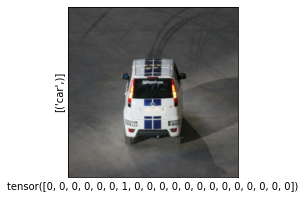

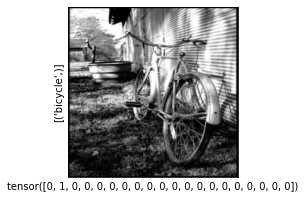

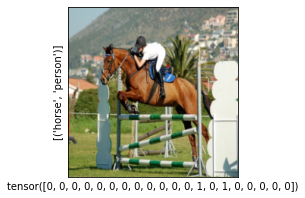

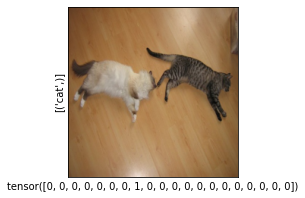

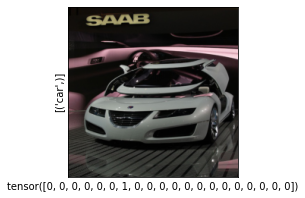

In [20]:
for i in range(8):
  fig = plt.figure(figsize = (14, 7))
  img_np = np.array(dataset[i][0])
  img=img_np.transpose(1,2,0)
  ax = fig.add_subplot(2, 4, i + 1, xticks = [], yticks = []) 
  plt.xlabel(dataset[i][1])    
  plt.ylabel(lb.inverse_transform(dataset[i][1].unsqueeze(0).numpy()))
  plt.imshow(img)
  

In [21]:
psum    = torch.tensor([0.0, 0.0, 0.0])
psum_sq = torch.tensor([0.0, 0.0, 0.0])

# loop through images
for inputs in complete:
  #inputs=np.array(input)

 
  psum    += inputs[0].sum(axis        = [0, 2, 3])
  psum_sq += (inputs[0] ** 2).sum(axis = [0, 2, 3])

In [22]:
count = len(df) * 224 * 224
total_mean = psum / count
total_var  = (psum_sq / count) - (total_mean ** 2)
total_std  = torch.sqrt(total_var)

# output
print('mean: '  + str(total_mean))
print('std:  '  + str(total_std))

mean: tensor([0.4485, 0.4250, 0.3920])
std:  tensor([0.2668, 0.2634, 0.2766])


In [23]:
transform_norm=transforms.Compose([
                              transforms.Resize([224,224]),
                              transforms.ToTensor(),
                              transforms.Normalize(total_mean,total_std)

                              ]
                             )

In [24]:
train_dataset=MultiDataset(folder_dir,labels,transform_norm,df_train)
valid_dataset=MultiDataset(folder_dir,valid_labels,transform_norm,df_valid)
train_dataloader=DataLoader(train_dataset,shuffle=True,batch_size=32,num_workers=2)
valid_loader=DataLoader(valid_dataset,batch_size=32,num_workers=2)

In [25]:
class MultiModel(nn.Module):
  def __init__(self,in_channels,out_channels,n_classes=20):
    super().__init__()

    self.conv1=nn.Conv2d(in_channels,out_channels,kernel_size=3,stride=1)
    self.batch1=nn.BatchNorm2d(out_channels)
    self.drop=nn.Dropout(.2)
    self.pool=nn.MaxPool2d(2,2)
    self.conv2=nn.Conv2d(out_channels,256,kernel_size=3,stride=1)
    self.batch2=nn.BatchNorm2d(256)
    self.conv3=nn.Conv2d(256,256,kernel_size=3,stride=1)
    self.batch3=nn.BatchNorm2d(256)
    self.adaptivepool=nn.AdaptiveMaxPool2d((1))
    self.linear=nn.Linear(256,256)
    self.linear2=nn.Linear(256,256)
    self.out=nn.Linear(256,n_classes)
    
    #self.sigmoid=nn.Sigmoid()

  def forward(self,x):
    x =self.pool(F.relu(self.conv1(x)))
    x=self.batch1(x)   
   # print(x.shape)
    x=self.drop(x)
    
    x =self.pool(F.relu(self.conv2(x)))
    #print(x.shape)
    x=self.batch2(x)
    x=self.drop(x)
    
    x =F.relu(self.conv3(x))
    x=self.drop(x)
    x=self.batch3(x)
    x=self.adaptivepool(x).squeeze()
    
    #x = x.view(x.size(0), -1)# flatten all dimensions except batch
    
    #print(x.shape)
    x = F.relu(self.linear(x))
    x = F.relu(self.linear2(x))
   
    
    x = self.out(x)
    #x=self.sigmoid(x)
    return x


In [26]:
model=MultiModel(3,128)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

MultiModel(
  (conv1): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1))
  (batch1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop): Dropout(p=0.2, inplace=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (batch2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
  (batch3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (adaptivepool): AdaptiveMaxPool2d(output_size=1)
  (linear): Linear(in_features=256, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=20, bias=True)
)

In [27]:
!pip install torchmetrics attrdict -q

     |████████████████████████████████| 419 kB 15.1 MB/s 


In [28]:
import torch.optim as optim
import torchmetrics

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)
metric = torchmetrics.F1Score()
metric=metric.to(device)

In [ ]:
train_losses_step = []
train_losses = []
valid_losses = []

#number of epoch high to reach
for epoch in range(35):
  running_loss = 0.0
  model.train()
  for i, data in enumerate(train_dataloader, 0):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs=inputs.to(device)
    labels=labels.to(device)
    

      # zero the parameter gradients
    optimizer.zero_grad()

      # forward + backward + optimize
    outputs = model(inputs)
   
    
    loss = criterion(outputs, labels.type(torch.float))
   
    loss.backward()
    optimizer.step()

    batch_acc = metric(outputs,labels.int())
    running_loss += loss.item()
    train_losses_step.append(loss.item())
  
  running_loss /= len(train_dataloader)
  train_losses.append(running_loss)
  train_acc = metric.compute()
 
  
  model.eval() 
  val_loss=0
  for i, data in enumerate(valid_loader, 0):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs=inputs.to(device)
    
    labels=labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels.type(torch.float))
    batch_acc = metric(outputs,labels.int())
    val_loss += loss.item()


  val_loss /= len(valid_loader)
  valid_losses.append(val_loss)
  valid_acc = metric.compute()
  
  
  print(f"Epoch: {epoch}, Train loss: {running_loss:.04f} Train acc: {float(train_acc):.04f}, Valid loss: {val_loss} Valid Acc: {float(valid_acc):.04f}")
     

In [ ]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(20,8))
ax1, ax2 = axes
ax1.plot(train_losses_step, label='Train Loss')
ax2.plot(train_losses, label='Train Loss')
ax2.plot(valid_losses, label='Valid Loss')
ax1.legend()
ax2.legend()
ax1.set_xlabel('Step')
ax1.set_ylabel('Cross Entropy Loss')
ax2.set_xlabel('Epoch')

### Testing the dataset

In [ ]:
df_test.labels=df_test.labels.str.split()
test_label=lb.fit_transform(df_test.labels)

test_dataset=MultiDataset(test_dir,test_label,transform_norm,df_test)

In [ ]:
for i in range(20):
  fig = plt.figure(figsize = (14, 7))
  x=test_dataset[i][0]
  img_np = np.array(x)
  x=x.unsqueeze(0)
  x=x.to(device)
  pred=model(x)
  pred=pred.detach().cpu()
  pred=pred.unsqueeze(0)
  pred=sigmoid(pred)
  pred=pred.round()
  pred=pred.numpy()
  f=lb.inverse_transform(pred)
  true_label=test_dataset[i][1].unsqueeze(0).numpy()
  img=img_np.transpose(1,2,0)
  ax = fig.add_subplot(2, 4, i + 1, xticks = [], yticks = []) 
  
  plt.title(true_label)
  plt.ylabel(f)
  plt.imshow(img)


In [ ]:
torch.save(model,"/content/model.pth")

In [ ]:
image=Image.open("/content/people-getting-plane.jpg")

In [ ]:
x=transform(image)

In [ ]:
x

In [ ]:
x=torch.tensor(x,dtype=torch.float32)

In [ ]:
x=x.unsqueeze(0)
x=x.to(device)

In [ ]:
x.shape

In [ ]:
pred=model(x)

In [ ]:
pred

In [ ]:
pred=pred.detach().cpu()

In [ ]:
pred=pred.unsqueeze(0)

In [ ]:
pred

In [ ]:
pred=sigmoid(pred)

In [ ]:
len(pred)

In [ ]:
pred=pred.round()

In [ ]:
pred=pred.numpy()

In [ ]:
pred.shape